## Packages

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from gensim.models import Word2Vec
import numpy as np



## Functions

In [18]:
def createVocabulary(corpus):
    """
    - Cria vocab (palavra e sua respectiva frequência no corpus)
    - Cria tokens (palavras do corpus)

    :param corpus: lista de string
    :return vocab, tokens, vocab_size:
    """
    tokens = []  # {'deeds', 'old', ...} 71666
    vocab = {}  # {'deeds': 2, 'old': 20', ...} 17971
    for text in corpus:
        for token in text.split():
            tokens.append(token)
            if token in vocab:
                vocab[token] += 1
            else:
                vocab[token] = 1
    vocab_size = len(vocab)
    return tokens, vocab, vocab_size

In [19]:
def findMaxLen(sequence):
    max_len = 0
    for text in sequence:
        if len(text) > max_len:
            max_len = len(text)
    return max_len

def findAverageLen(sequence):
    total_len = 0
    for text in sequence:
        total_len += len(text)
    return total_len / len(sequence)

## Load data

In [20]:
df_pp = pd.read_csv('../../assets/df_pp.csv')
df_pp

,title,tags,link,label,label_encoded
0,dividendos as <NUM> acoes preferidas <NUM> ana...,"['Carteira Recomendada', 'Comprar ou vender?',...",https://www.moneytimes.com.br/dividendos-as-10...,1,1
1,itau jhsf banco brasil confira agenda resultad...,"['Alper (APER3)', 'balanços trimestrais', 'Bol...",https://www.suno.com.br/noticias/itau-jhsf-ban...,2,2
2,destaques empresas petrobras petr4 jbs jbss3 h...,"['Arezzo (ARZZ3)', 'Cia Hering (HGTX3)', 'dest...",https://www.suno.com.br/noticias/destaques-de-...,0,0
3,itau unibanco itub4 vai pagar proventos comeco...,"['Bancos', 'Dividendos', 'Empresas', 'Itaú Uni...",https://www.moneytimes.com.br/itau-unibanco-it...,2,2
4,petrobras petr4 elege novo conselho maior part...,"['Ações', 'Adriano Pires', 'Combustíveis', 'Em...",https://www.moneytimes.com.br/petrobras-petr4-...,0,0
...,...,...,...,...,...
11951,petrobras guia nova maxima ibovespa sessao meg...,"['Ações', 'Empresas', 'Ibovespa', 'Leilão', 'M...",https://www.moneytimes.com.br/petrobras-guia-n...,0,0
11952,petrobras estende vencimento emprestimo banco ...,"['Empresas', 'Petrobras']",https://www.moneytimes.com.br/petrobras-estend...,0,0
11953,petrobras percepcao risco sobre politica preco...,"['Ações', 'Combustíveis', 'Commodities', 'Comp...",https://www.moneytimes.com.br/petrobras-percep...,0,0
11954,bndes espera vender cerca <NUM> bi debentures ...,"['BNDES', 'BNDESPar', 'debêntures', 'Vale (VAL...",https://www.suno.com.br/noticias/bndes-venda-d...,1,1


## Splitting Dataset

In [21]:
X = df_pp.title
y = df_pp.label

In [22]:
# Split data into train and test
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, random_state=52)  # 80% train

X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=52)  # 10% val, 10% testc

In [23]:
print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

0    4877
1    3007
2    1680
Name: label, dtype: int64
0    646
1    349
2    201
Name: label, dtype: int64
0    590
1    384
2    222
Name: label, dtype: int64


## Tokenization, Vocabulary

In [24]:
tokens, vocab, vocab_size = createVocabulary(X_train)
len(vocab)

8010

## Numericalization

In [25]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(X_train)

## Padding

In [26]:
max_len = findMaxLen(train_sequences)
max_len = int(max_len/2)

In [27]:
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')

val_sequences = tokenizer.texts_to_sequences(X_val)
val_padded = pad_sequences(val_sequences, maxlen=max_len, padding='post', truncating='post')

## Load word2vec model

In [28]:
model = Word2Vec.load('../../assets/word2vec.model')

model.wv.most_similar('petrobras')

[('petr4', 0.9969706535339355),
 ('venda', 0.9732074737548828),
 ('diz', 0.9684100151062012),
 ('arrecada', 0.9663283824920654),
 ('sal', 0.9640135169029236),
 ('natural', 0.9576036334037781),
 ('premenos', 0.9558805227279663),
 ('inicia', 0.9553847312927246),
 ('bolsonaro', 0.9515899419784546),
 ('governo', 0.9483191967010498)]

In [29]:
# List of nparrays of size 300
embeddings_dict = {}
for i, word in enumerate(model.wv.index_to_key):
    embeddings_dict[word] = model.wv[word]

In [30]:
# create matrix with vocab train words
embeddings_on_this_context = np.zeros((len(word_index), 300))
for word, i in word_index.items():
    embeddings_vector = embeddings_dict.get(word)
    if embeddings_vector is not None:
        embeddings_on_this_context[i - 1] = embeddings_vector

## RNN Model

### Packages

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.losses import BinaryCrossentropy

from keras.optimizers import Adam
import matplotlib.pyplot as plt

### Functions

In [32]:
def index2word(word_index):
    index_word = {}
    for key in word_index:
        index_word[word_index[key]] = key
    return index_word


def seq2text(seq, index_word):
    text = []
    for index in seq:
        text.append(index_word[index])
    return text

def show_confusion_matrix(cm):
        print("Confusion Matrix")
        plt.figure(figsize=(10, 7))

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('Truth')
        plt.title('Confusion Matrix')
        plt.show()

### Declaration

In [33]:
model = Sequential([
    Embedding(input_dim=vocab_size+1, output_dim= 300, input_length=max_len, trainable=False, weights=[embeddings_on_this_context]),
    Bidirectional(LSTM(64, return_sequences=True)),
    # Dropout(0.4),
    # Bidirectional(LSTM(hp.Choice('units',[32,64]))),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    # Dropout(0.6),
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 11, 300)           2403300   
                                                                 
 bidirectional (Bidirectiona  (None, 11, 128)          186880    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 2,693,223
Trainable params: 289,923
Non-tr

### Training

In [34]:
# loss = BinaryCrossentropy(from_logits=False)
# optimizer = Adam(0.0001)
# metrics = ['accuracy']
# model.compile(loss=loss,optimizer=optimizer,metrics=metrics)
#
# history = model.fit(train_padded, y_train, epochs=30, validation_data=(val_padded,y_val), verbose=2)


In [36]:
from keras.optimizers import SGD

loss = "sparse_categorical_crossentropy"
optimizer = SGD(learning_rate=0.01)
metrics = ['accuracy']


In [37]:
model.compile(loss=loss,optimizer=optimizer,metrics=metrics)

history = model.fit(train_padded, y_train, epochs=10, validation_data=(val_padded,y_val), verbose=2)


Epoch 1/10
299/299 - 14s - loss: 1.0138 - accuracy: 0.5099 - val_loss: 0.9744 - val_accuracy: 0.5401 - 14s/epoch - 45ms/step
Epoch 2/10
299/299 - 5s - loss: 0.9628 - accuracy: 0.5388 - val_loss: 0.9184 - val_accuracy: 0.6070 - 5s/epoch - 15ms/step
Epoch 3/10
299/299 - 4s - loss: 0.8957 - accuracy: 0.6129 - val_loss: 0.8451 - val_accuracy: 0.6405 - 4s/epoch - 13ms/step
Epoch 4/10
299/299 - 5s - loss: 0.8249 - accuracy: 0.6499 - val_loss: 0.7841 - val_accuracy: 0.6614 - 5s/epoch - 16ms/step
Epoch 5/10
299/299 - 5s - loss: 0.7579 - accuracy: 0.6812 - val_loss: 0.7068 - val_accuracy: 0.6990 - 5s/epoch - 16ms/step
Epoch 6/10
299/299 - 5s - loss: 0.6877 - accuracy: 0.7221 - val_loss: 0.6450 - val_accuracy: 0.7467 - 5s/epoch - 17ms/step
Epoch 7/10
299/299 - 5s - loss: 0.6428 - accuracy: 0.7468 - val_loss: 0.6057 - val_accuracy: 0.7575 - 5s/epoch - 16ms/step
Epoch 8/10
299/299 - 6s - loss: 0.6257 - accuracy: 0.7532 - val_loss: 0.5864 - val_accuracy: 0.7692 - 6s/epoch - 19ms/step
Epoch 9/10
299

### Evaluation

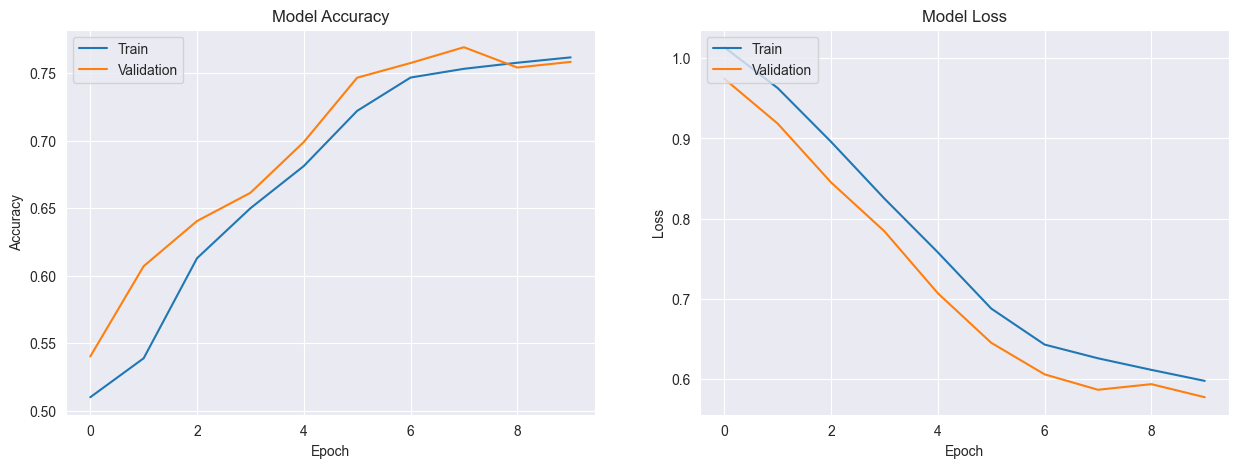

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Predictions

In [39]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

In [43]:
index_word = index2word(word_index)

In [40]:
pred_prob = model.predict(test_padded)


38/38 [==============================] - 2s 6ms/step


In [ ]:
# y_pred = [1 if p > 0.5 else 0 for p in pred_prob]


In [46]:
y_pred = np.argmax(pred_prob, axis=1)

In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       590
           1       0.75      0.79      0.77       384
           2       0.59      0.50      0.54       222

    accuracy                           0.76      1196
   macro avg       0.72      0.71      0.71      1196
weighted avg       0.75      0.76      0.75      1196



In [48]:
df_results = pd.DataFrame()
X_test = list(X_test)
y_test = list(y_test)
df_results['sequence'] = test_sequences
df_results['X_test'] = X_test
df_results['seq2text'] = df_results['sequence'].apply(lambda x: seq2text(x, index_word))
df_results['y_pred'] = y_pred
df_results['y_true'] = y_test
df_results

,sequence,X_test,seq2text,y_pred,y_true
0,"[47, 2, 550, 1029, 3559, 33]",sobe <NUM> numero mortos identificados brumadinho,"[sobe, num, numero, mortos, identificados, bru...",2,1
1,"[11, 12, 86, 153, 25, 962, 987, 236]",minerio ferro china forte queda piora perspect...,"[minerio, ferro, china, forte, queda, piora, p...",1,1
2,"[152, 1599, 49, 109, 4340, 265, 48, 444]",exmenos socio btg quer transformar bndes banco...,"[exmenos, socio, btg, quer, transformar, bndes...",0,0
3,"[89, 3, 7, 151, 3912, 1173, 245, 101]",ceo petrobras diz coronavirus afetou exportaco...,"[ceo, petrobras, diz, coronavirus, afetou, exp...",0,0
4,"[80, 11, 12, 129, 146, 15, 44]",futuros minerio ferro tem leve alta dalian,"[futuros, minerio, ferro, tem, leve, alta, dal...",1,1
...,...,...,...,...,...
1191,"[3, 265, 442, 1288, 174, 1, 123, 2, 29, 9, 24,...",petrobras bndes cria concorrencia b3 nyse vend...,"[petrobras, bndes, cria, concorrencia, b3, <OO...",0,0
1192,"[507, 9, 202, 1, 433, 79, 2, 114, 94]",ofertas acoes devem concentrar grandes empresa...,"[ofertas, acoes, devem, <OOV>, grandes, empres...",1,0
1193,"[4, 154, 11, 12, 2, 63, 68, 182, 133]",vale com minerio ferro <NUM> bradesco eleva pr...,"[vale, com, minerio, ferro, num, bradesco, ele...",1,1
1194,"[506, 1275, 76, 121, 2377]",pedro serra br distribuidora vir,"[pedro, serra, br, distribuidora, vir]",0,0


### Metrics

In [55]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(average='macro', y_true=y_test, y_pred=y_pred)
recall = recall_score(average='macro', y_true=y_test, y_pred=y_pred)
f1 = f1_score(average='macro', y_true=y_test, y_pred=y_pred)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       590
           1       0.75      0.79      0.77       384
           2       0.59      0.50      0.54       222

    accuracy                           0.76      1196
   macro avg       0.72      0.71      0.71      1196
weighted avg       0.75      0.76      0.75      1196

Confusion Matrix


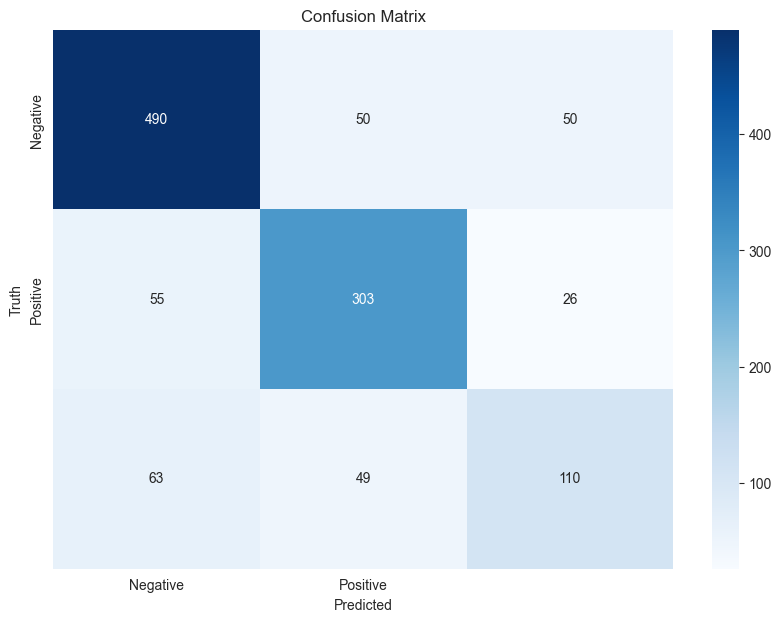

In [56]:
print(classification_report(y_test,y_pred))
show_confusion_matrix(cm)